#JPMorgan Quantitative Research
##Task 2: Price a commodity storage contract

Mounted at /content/drive
      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9


/tmp/ipython-input-940521146.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(dates)


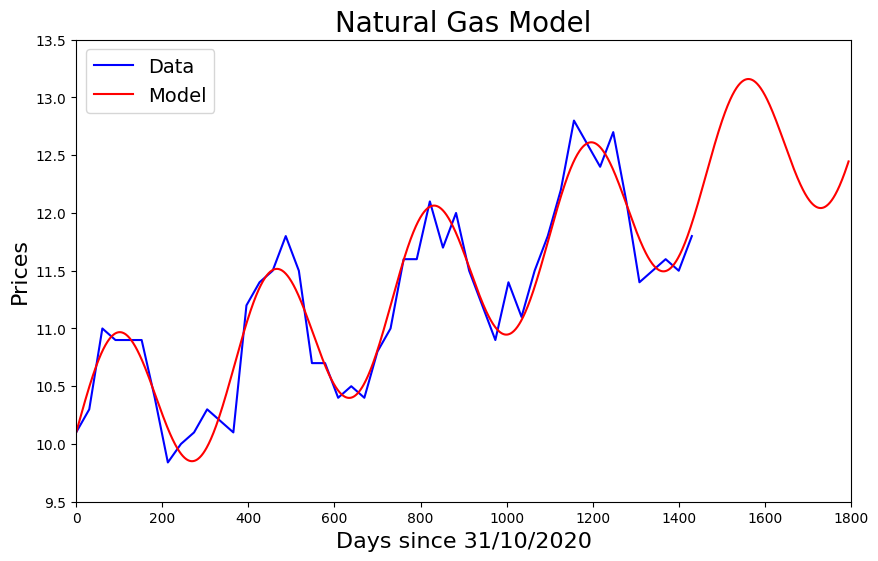

In [11]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from google.colab import drive
import datetime

# read and check the file
drive.mount('/content/drive', force_remount = True)
file_path = '/content/drive/My Drive/Forage/Nat_Gas.csv'
nat_gas_data = pd.read_csv(file_path)
print(nat_gas_data.head())

prices = nat_gas_data['Prices']
dates = nat_gas_data['Dates']
dates = pd.to_datetime(dates)

# model the data
def curve(x, a, b, c, d):
  return a + b * x + c * np.sin((2 * np.pi/365) * x + d)

xdata = (dates - dates.min()) / np.timedelta64(1, 'D')
ydata = prices
popt, pcov = curve_fit(curve, xdata, ydata)

a_fit, b_fit, c_fit, d_fit = popt
x_fit = np.arange(0, max(xdata) + 365, 1)
y_fit = curve(x_fit, a_fit, b_fit, c_fit, d_fit)

plt.figure(figsize = (10, 6))
plt.plot(np.linspace(0, max(xdata), 48), prices, label = 'Data', color = 'b')
plt.plot(x_fit, y_fit, label = 'Model', color = 'r')
plt.xlim(0, 1800)
plt.ylim(9.5, 13.5)
plt.xticks(np.arange(0, 2000, 200))
plt.yticks(np.arange(9.5, 14, 0.5))
plt.xlabel('Days since 31/10/2020', fontsize = 16)
plt.ylabel('Prices', fontsize = 16)
plt.title('Natural Gas Model', fontsize = 20)
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

In [12]:
'''
Model the value of a natural gas storage contract.

Assumptions:
- 'Dates' in the CSV file represent the date for each market price entry.
- 'Prices' in the CSV file represent the spot market value of natural gas in USD per MMBtu.
- Market prices are estimated for any given date using a fitted curve based on historical data.
- No transport delays and zero interest rates are assumed.
- The maximum storage capacity is 1×10^7 MMBtu.
- Storage cost: $0.02 per MMBtu per month (CME Group example).
- Financing cost: $0.015 per MMBtu per month (CME Group example).
- Injection cost: $0.01 per MMBtu (Forage example).
- Withdrawal cost: $0.01 per MMBtu (Forage example).
- Transportation cost: $0.10 per MMBtu.

References:
- CME Group: Understanding Natural Gas Risk Management, Spreads & Storage:
  https://www.cmegroup.com/education/courses/introduction-to-natural-gas/understanding-natural-gas-risk-management-spreads-storage.html
- U.S. Energy Information Administration (EIA): Weekly Natural Gas Storage Report:
  https://www.eia.gov/naturalgas/storage/
- Forage: Task 2: Price a Commodity Storage Contract:
  https://www.theforage.com/virtual-experience/bWqaecPDbYAwSDqJy/j-p-morgan/quantitative-research-11oc/price-a-commodity-storage-contract
'''

def contract_price(number_injections, number_withdrawals):
  # track profit, storage volume and key injection values
  profit = 0
  storage_volume = 0
  max_storage_capacity = 10**7
  injections = []

  start = datetime.date(2020, 10, 31)
  end = datetime.date(2025, 9, 30)

  # model injections
  last_injection_date = datetime.date(2020, 10, 30)
  for i in range(1, number_injections + 1):
    print('Injection {}:'.format(i))
    while True:
      try:
        injection_date = datetime.datetime.strptime(input('Please enter a date to inject the natural gas: '), '%d/%m/%Y').date()
        if (start <= injection_date <= end) and (injection_date > last_injection_date):
          break
        else:
          print('Date outside valid range.')
      except ValueError:
        print('This is not a valid date.')

    last_injection_date = injection_date

    while True:
      try:
        injection_volume = float(input('Please enter how much natural gas that will be injected in MMBtu: '))
        if 0 < injection_volume <= (max_storage_capacity - storage_volume):
          break
        else:
          print('This is not a valid quantity')
      except ValueError:
        print('This is not a valid quantity.')

    # purchase cost + injection cost + transport cost
    injection_date_fit = (pd.to_datetime(injection_date, dayfirst = True) - dates.min()) / np.timedelta64(1, 'D')
    injection_price = curve(injection_date_fit, a_fit, b_fit, c_fit, d_fit) * injection_volume
    injection_cost = 0.01 * injection_volume
    injection_transport_cost = 0.10 * injection_volume
    profit -= injection_price + injection_cost + injection_transport_cost
    storage_volume += injection_volume
    injections.append([injection_date, injection_volume])

  # model withdrawals
  last_withdrawal_date = datetime.date(2020, 10, 31)
  for j in range(1, number_withdrawals + 1):
    print('Withdrawal {}:'.format(j))
    while True:
      try:
        withdrawal_date = datetime.datetime.strptime(input('Please enter a date to withdraw the natural gas: '), '%d/%m/%Y').date()
        if (start <= withdrawal_date <= end) and (withdrawal_date > injections[0][0]) and (withdrawal_date > last_withdrawal_date):
          break
        else:
          print('Date outside valid range.')
      except ValueError:
        print('This is not a valid date.')

    last_withdrawal_date = withdrawal_date

    while True:
      try:
        withdrawal_volume = float(input('Please enter how much natural gas that will be withdrawn in MMBtu: '))
        if 0 < withdrawal_volume <= storage_volume:
          break
        else:
          print('This is not a valid quantity')
      except ValueError:
        print('This is not a valid quantity.')

    # sale revenue - withdrawal cost - transport cost - storage cost
    withdrawal_date_fit = (pd.to_datetime(withdrawal_date, dayfirst = True) - dates.min()) / np.timedelta64(1, 'D')
    withdrawal_cost = 0.01 * withdrawal_volume
    withdrawal_transport_cost = 0.10 * withdrawal_volume

    volume_to_withdraw = withdrawal_volume

    while volume_to_withdraw > 0 and injections:
      inj_date, inj_volume = injections[0]
      take_volume = min(volume_to_withdraw, inj_volume)

      withdrawal_price = curve(withdrawal_date_fit, a_fit, b_fit, c_fit, d_fit) * take_volume
      profit += withdrawal_price
      profit -= (withdrawal_cost * (take_volume / withdrawal_volume))
      profit -= (withdrawal_transport_cost * (take_volume / withdrawal_volume))

      storage_days = (withdrawal_date - inj_date).days
      storage_cost = 0.02 * take_volume * (storage_days / 30)
      profit -= storage_cost

      financing_cost = 0.015 * take_volume * (storage_days / 30)
      profit -= financing_cost

      injections[0][1] -= take_volume
      if injections[0][1] <= 0:
        injections.pop(0)
      volume_to_withdraw -= take_volume

    storage_volume -= withdrawal_volume

  return profit

print('This program gives you the contract of storing natural gas between 31st October 2020 to 30th September 2025.\nMake sure the date you type is in the format DD/MM/YYYY, e.g. 14/05/2023.')

while True:
  try:
    number_injections = int(input('Please enter how many injections you would like to execute: '))
    if number_injections > 0:
      break
    else:
      print('This is not a valid number.')
  except ValueError:
    print('This is not a valid number.')

while True:
  try:
    number_withdrawals = int(input('Please enter how many withdrawals you would like to execute: '))
    if number_withdrawals > 0:
      break
    else:
      print('This is not a valid number.')
  except ValueError:
    print('This is not a valid number.')

profit = contract_price(number_injections, number_withdrawals)
print('Estimated contract value: ${}.'.format(round(profit, -3)))

This program gives you the contract of storing natural gas between 31st October 2020 to 30th September 2025.
Make sure the date you type is in the format DD/MM/YYYY, e.g. 14/05/2023.
Please enter how many injections you would like to execute: 3
Please enter how many withdrawals you would like to execute: 3
Injection 1:
Please enter a date to inject the natural gas: 14/07/2021
Please enter how much natural gas that will be injected in MMBtu: 10000
Injection 2:
Please enter a date to inject the natural gas: 14/07/2022
Please enter how much natural gas that will be injected in MMBtu: 10000
Injection 3:
Please enter a date to inject the natural gas: 14/07/2023
Please enter how much natural gas that will be injected in MMBtu: 10000
Withdrawal 1:
Please enter a date to withdraw the natural gas: 14/02/2022
Please enter how much natural gas that will be withdrawn in MMBtu: 10000
Withdrawal 2:
Please enter a date to withdraw the natural gas: 14/02/2023
Please enter how much natural gas that wil